In [2]:
# Connect Driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import matplotlib.pyplot as plt
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D, GRU
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, Normalizer

In [4]:
CSV_HEADER = [
    "dur", "proto", "service", "state", "spkts", "dpkts", "sbytes", "dbytes", "rate", "sttl", "dttl",
    "sload", "dload", "sloss", "dloss", "sinpkt", "dinpkt", "sjit", "djit", "swin", "stcpb", "dtcpb",
    "dwin", "tcprtt", "synack", "ackdat", "smean", "dmean", "trans_depth", "response_body_len",
    "ct_srv_src", "ct_state_ttl", "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm",
    "ct_dst_src_ltm", "is_ftp_login", "ct_ftp_cmd", "ct_flw_http_mthd", "ct_src_ltm",
    "ct_srv_dst","is_sm_ips_ports","label"
] # drop attack_cat,

In [5]:
def read_data(path_train,path_test): #CSV_HEADER
  # train_data = pd.read_csv(path_train, header=None, names=CSV_HEADER)
  # test_data = pd.read_csv(path_test, header=None, names=CSV_HEADER)
  train_data = pd.read_csv(path_train)
  test_data = pd.read_csv(path_test)
  train_data = train_data.drop(['attack_cat'], axis=1)
  test_data = test_data.drop(['attack_cat'], axis=1)
  train_data = train_data.drop(['id'], axis=1)
  test_data = test_data.drop(['id'], axis=1)
  print(f"Train dataset shape: {train_data.shape}")
  print(f"Test dataset shape: {test_data.shape}")
  return train_data, test_data
#/content/drive/MyDrive/BigDataAgain/Dataset/NSL-KDD/NSL_KDD_Train.csv
#/content/drive/MyDrive/BigDataAgain/Dataset/NSL-KDD/NSL_KDD_Test.csv

In [15]:
def preprocess_categorical_features(train_data,test_data):
  train_data['service']=train_data['service'].apply(lambda x: 'none' if x=='-' else x )
  test_data['service']=test_data['service'].apply(lambda x: 'none' if x=='-' else x )
  train_data['state']=train_data['state'].apply(lambda x: 'none' if x=='-' else x )
  test_data['state']=test_data['state'].apply(lambda x: 'none' if x=='-' else x )
  CATEGORICAL_FEATURE_NAMES = ["proto","service","state"]
  # Danh sách các cột cần Label Encode
  CATEGORICAL_FEATURE_NAMES = ["proto","service","state"]

  # Label Encoding cho từng cột
  label_encoders = {}
  for col in CATEGORICAL_FEATURE_NAMES:
      label_encoder = LabelEncoder()
      train_data[col] = label_encoder.fit_transform(train_data[col])
      test_data[col] = label_encoder.fit_transform(test_data[col])
      label_encoders[col] = label_encoder  # Lưu lại encoder nếu cần inverse_transform sau này
  return train_data,test_data

In [7]:
def preprocess_numeric_features(train_data,test_data):
  #Preprocessing Numerical Features.
  scaler_train = StandardScaler()
  scaler_train = scaler_train.fit(train_data[CSV_HEADER])
  train_data[CSV_HEADER] = scaler_train.transform(train_data[CSV_HEADER])

  scaler_test = StandardScaler()
  scaler_test = scaler_test.fit(test_data[CSV_HEADER])
  test_data[CSV_HEADER] = scaler_test.transform(test_data[CSV_HEADER])
  return train_data,test_data

In [8]:
def exchange_label(train_data,test_data):

  #Convert "label" into normal=0 and attack=1 for KDDTrain+
  train_data['label']=train_data['label'].apply(lambda x: 'ibnormal' if x==1 else 'normal')
  #train_data.drop(['label'], axis=1)

  #Convert "label" into normal=0 and attack=1 for KDDTest+
  test_data['label']=test_data['label'].apply(lambda x: 'ibnormal' if x==1 else 'normal')
  #test_data.drop(['label'],1)

  train_data = train_data.fillna(axis=0, method='ffill')
  test_data = test_data.fillna(axis=0,method='ffill')
  return train_data, test_data

In [9]:
def save_file(train_data,test_data):
  train_data_file = "train_data.csv"
  test_data_file = "test_data.csv"

  train_data.to_csv(train_data_file, index=False, header=False)
  test_data.to_csv(test_data_file, index=False, header=False)
  return train_data_file, test_data_file

In [16]:
train_data,test_data = read_data("/content/drive/MyDrive/AnToanHeThongThongTin-CH2024/UNSW_NB15_training-set.csv","/content/drive/MyDrive/AnToanHeThongThongTin-CH2024/UNSW_NB15_testing-set.csv")
train_data,test_data = preprocess_categorical_features(train_data,test_data)
train_data,test_data = preprocess_numeric_features(train_data,test_data)
train_data, test_data = exchange_label(train_data,test_data)
train_data_file,test_data_file = save_file(train_data,test_data)

Train dataset shape: (175341, 43)
Test dataset shape: (82332, 43)


<ipython-input-8-8a9be518ca17>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(axis=0, method='ffill')
<ipython-input-8-8a9be518ca17>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(axis=0,method='ffill')


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def create_ann_model(input_shape=(42,), hidden_units=None):
    """
    Create a feedforward neural network model for binary classification with
    the specified input shape.

    Parameters:
    - input_shape: Tuple specifying the shape of the input data.
    - hidden_units: List of integers specifying the number of units in each hidden layer.
                    Default is [64, 32].

    Returns:
    - A compiled Keras model.
    """
    if hidden_units is None:
        hidden_units = [64, 32]

    model = Sequential()

    # Input layer
    model.add(Dense(hidden_units[0], activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))

    # Hidden layers
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [52]:
# Đọc dữ liệu từ file CSV không có header
train_data = pd.read_csv('/content/train_data.csv', header=None)
  # Lấy tất cả các cột trừ cột cuối (label)
train_labels = train_data.values[:, -1]  # Lấy cột cuối làm nhãn (label)
train_labels = np.where(train_labels == 'normal', 0, 1) # 'normal' -> 0, other ->1
train_data = train_data.values[:, :-1].astype(np.float32)
truclb_model = create_ann_model()
truclb_model.fit(
    train_data,         # Dữ liệu đầu vào
    train_labels,       # Nhãn đầu ra
    epochs=1,          # Số epoch (lần lặp qua dữ liệu)
    batch_size=32,      # Kích thước batch
    validation_split=0.5  # Chia 20% dữ liệu để validation
)
truclb_model.save('truclb_model_ver1-0.keras')  # Lưu mô hình dưới dạng SavedModel

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2740/2740 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9767 - loss: 0.0517 - val_accuracy: 1.0000 - val_loss: 8.8305e-05


In [53]:
# Đọc dữ liệu từ file CSV không có header
test_data = pd.read_csv('/content/test_data.csv', header=None)
  # Lấy tất cả các cột trừ cột cuối (label)
test_labels = test_data.values[:, -1]  # Lấy cột cuối làm nhãn (label)
test_labels = np.where(test_labels == 'normal', 0, 1) # 'normal' -> 0, other ->1
test_data = test_data.values[:, :-1].astype(np.float32)

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82332

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332

_______________________CONFUSION MATRIX_______________________


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

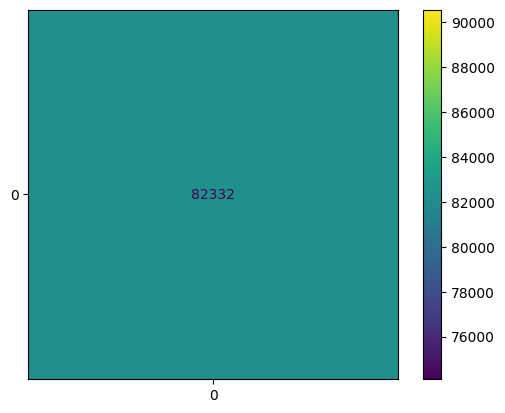

In [54]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix , classification_report, recall_score, precision_score,f1_score
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

model_reload = load_model('truclb_model_ver1-0.keras')
y_pred = model_reload.predict(test_data)
def print_Report(y_true,y_pred_bool):
    print(classification_report(y_true, y_pred_bool))
    #20/12
    #Confusion matrix -> vẽ và phân tích.
    print('_______________________CONFUSION MATRIX_______________________')
    cm = confusion_matrix(y_true,y_pred_bool)
    cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    cmp.plot()
    return
print_Report(test_labels,K.round(y_pred))